Schaefer (2007): The Hubble Diagram to Redshift >6 from 69 Gamma-ray Bursts
---

In table 6 of this paper, Schaefer presents 6 columns of $\mu$ magnitudes (distance modulus). The first five, subscripted by numerics from 1-5, are the magnitues calculated using five different luminosity-distance relations. The column just following those, which we refer to as `maga`, is the weighted average of these (see calculations for this below). The last column, which we refer to as `magb`, is the distance modulus derived from a Riess cosmolog ($w_0=-1.31$ and $w'=1.48$). 

The distance moduli and their $1\sigma$ uncertainties for all 5 relations: $\mu_1 \pm \sigma_{\mu_1}$, $\mu_2 \pm \sigma_{\mu_2}$, $\mu_3 \pm \sigma_{\mu_3}$, $\mu_4 \pm \sigma_{\mu_4}$, and $\mu_5 \pm \sigma_{\mu_5}$.

Not every GRB has all 5 $\mu$ from the luminosity-distance relations, hence the need for a weighted average. 

The best estimate $\mu$ for each GRB will be the weighted average of all available distance moduli. Thus, the derived distance modulus for each burst will be:

\begin{equation}
\mu = \frac{\sum_{i} \mu_i /\sigma_{\mu_i}^2}{\sum_{i} \sigma_{\mu_i}^{-2}}
\end{equation}

and its uncertainty will be:

\begin{equation}
\sigma_{\mu} = \left( \sum_i \sigma_{\mu_i}^{-2} \right)^{-1/2}
\end{equation}

These are Equation 28-29.

These are weighted averages for each single GRB, not sample statistics. 



In [1]:
from __future__ import division
import os

import numpy as np
import pandas as pd

from numpy import pi, sqrt
from scipy import integrate
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline

$D_L$ for Cosmology Models
---

In [2]:
def LumDist_concordance(redshift, H_knot=None, omega_m=None):
    """
    This is the function we use in our work, but different cosmo constants 
    as well as DL units. 
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    def Aint(z):
        return (1./(sqrt(((1.+z)*(1.+z)*(1. + omega_m * z))-(z*(2.+ z)*omega_l ))))
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_riess(redshift, H_knot=None, omega_m=None):
    """
    Lower order expansion for dark energy term (w). Equation 14 in Riess et al. 2004. 
    w(z) = w0 + w'z
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    if omega_m is None:
        omega_m     = 0.27             # Matter Density.
    omega_l     = 1.0 - omega_m
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    w0 = -1.31
    wp = 1.48   # p: prime symbol
    def Aint(z):
        return 1./np.sqrt( ((1.+z)**3)*omega_m + \
                         omega_l*((1.+z)**(3*(1+w0-wp)))*np.exp(3*wp*z) )
    AA      = integrate.quad(Aint, 0.0, z)
    DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc


def LumDist_weylgravity(redshift, H_knot=None):
    """
    Weyl Gravity.
    Equation 237 in Mannheim 2006 paper
    q_knot      = -0.37 or -0.2
    """
    z           = redshift
    if H_knot is None:
        H_knot      = 71.               # Hubble Constant.  Units: km/s/Mpc
    c           = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
    q_knot      = -0.37
    DL_Mpc  = (-c * ((1. + z)**2) / (H_knot * q_knot)) * \
                (1-np.sqrt(1 + q_knot - (q_knot/((1+z)**2))))
    DL_pc = DL_Mpc * (1E6) # convert Mpc to pc
    return DL_pc

# def LumDist_wexpansion_2(redshift):
#     H_knot      = 71               # Hubble Constant.  Units: km/s/Mpc
#     omega_m     = 0.27             # Matter Density.
#     omega_l     = 1.0 - omega_m
#     c          = 2.99792458e5      # SPEED OF LIGHT    Units: km/s
#     w0 = -1.31
#     wa = 

#     z = redshift
#     def Aint(z):
#         return 1./np.sqrt( ((1.+z)**3)*omega_m + \
#                          omega_l*((1.+z)**(3*(1+w0+wa)))*np.exp(-3*wz*z/(1+z)) )
#     AA      = integrate.quad(Aint, 0.0, z)
#     DL_Mpc  = (c * (1. + z) / H_knot) * AA[0]
#     DL_pc = DL_Mpc * (1E6)
#     return DL_pc

    
def distance_modulus(lumdistance):
    return 5*np.log10(lumdistance)-5


def get_moduli(model, redshifts=None, H_knot=None, omega_m=None):
    """
    model : str. 'concord', 'weyl', or 'riess'
                    or 'c', 'w', and 'r'
    
    """
    H0 = H_knot
    OM = omega_m
    if model.startswith('c'):   
        DLs = [LumDist_concordance(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('r'):   
        DLs = [LumDist_riess(redshift=z, H_knot=H0, omega_m=OM) for z in redshifts]
    elif model.startswith('w'):   
        DLs = [LumDist_weylgravity(redshift=z, H_knot=H0) for z in redshifts]
    moduli = [distance_modulus(lumdistance=dL) for dL in DLs]
    return moduli

In [3]:
def plot_format(xdata, ydata, xerr, yerr, xLims, yLims, ax=None, **pltKwargs):
    if not pltKwargs:
        pltKwargs = dict(fmt='.', color='blue', lw=1, capsize=1)
    plt.clf()
    if ax:
        print('clearning axes')
        ax.clear()
        ax.cla()
    plt.figure(figsize=(5, 3.5))
    if ax is None:
        ax = plt.gca()
    
    #  ***** Plot cosmological models:
    redshifts = np.linspace(0, 7, 100)
    PLT = ax.plot(redshifts, get_moduli(model='c', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='k', alpha=0.35, label='Concorance Cosmology')
    ax.plot(redshifts, get_moduli(model='r', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='red', alpha=0.35, label="Riess: $w(z) = w_0 + w'z$")
    ax.plot(redshifts, get_moduli(model='w', redshifts=redshifts, H_knot=None, omega_m=None), 
            color='blue', alpha=0.35, label='Weyl Gravity') 
        
    # z, mag
    ax.errorbar(xdata, ydata, yerr=yerr, xerr=xerr, **pltKwargs)
    ax.axvline(1.4, 0, 1, alpha=0.75, color='k', ls='--')
    
    ax.minorticks_on()
    ax.set_xlim(*xLims)
    ax.set_ylim(*yLims)
    ax.legend(loc=4, fontsize=11, labelspacing=0.1)
    ax.set_xlabel('$z$', fontsize=14)
    ax.set_ylabel('$\mu$', fontsize=14)
    #plt.show()
    return PLT

### $\mu$ and the uncertainty in $\mu$ ($\sigma_{\mu}$) as given by equations 28 and 29 in Schaefer et al (2007)

In [4]:
# mu = lambda values,errors: np.nansum([i/(j**2) for i,j in zip(values,errors)])/np.nansum([(j**-2.) for j in errors])
# mu_unc = lambda errors: (np.nansum([(j**-2.) for j in errors]))**-0.5

def mu(values, errors):
    a = []
    b = []
    for val,err in zip(values,errors):
        a.append(val/(err**2))
        b.append(err**-2.)
    a = np.nansum(a)
    b = np.nansum(b)
    return a/b

def mu_unc(errors):
    a = []
    for err in errors:
        a.append(err**-2.)
    a = np.nansum(a)
    a = a**-0.5
    return a

Begin Program
---

### Read In Data

In [5]:
# # Supernovae data from Kowalski et al. 2008, table 11
# df1 = pd.read_csv('Kowalski2008_table11.txt', 
#                   sep='\t')

# GRB data from Schaefer 2007, table 6
df = pd.read_csv('Schaefer2007_table6.txt', 
                  sep='\t')
cols = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5'] #, 'maga', 'magb']

cols_vals = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5']
cols_errs = ['mag1_err', 'mag2_err', 'mag3_err', 'mag4_err', 'mag5_err']


bursts = df.GRB.tolist()

In [6]:
df.head()

,GRB,z,mag1,mag1_err,mag2,mag2_err,mag3,mag3_err,mag4,mag4_err,mag5,mag5_err,maga,maga_err,magb,magb_err
0,970228,0.70,NaN,NaN,42.53,1.31,42.41,1.16,NaN,NaN,43.42,1.21,42.79,0.71,42.56,0.70
1,970508,0.84,43.09,1.19,43.13,1.34,45.66,1.04,43.92,0.63,43.09,1.20,43.92,0.43,43.68,0.44
2,970828,0.96,NaN,NaN,42.99,1.28,44.07,1.03,43.61,0.63,43.27,1.25,43.58,0.46,43.32,0.48
3,971214,3.42,48.76,1.50,48.69,1.19,47.55,1.04,NaN,NaN,49.33,1.33,48.44,0.62,48.06,0.61
4,980613,1.10,NaN,NaN,NaN,NaN,45.85,1.33,NaN,NaN,NaN,NaN,45.85,1.33,45.63,1.30


Plots
---

/Users/KimiZ/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log10


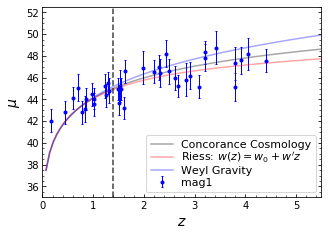

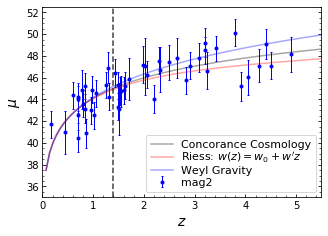

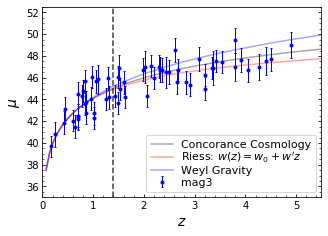

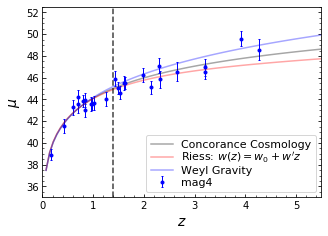

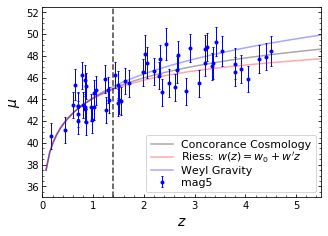

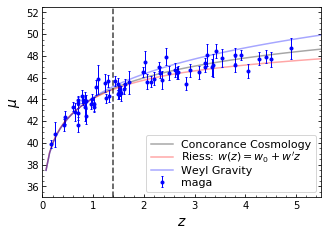

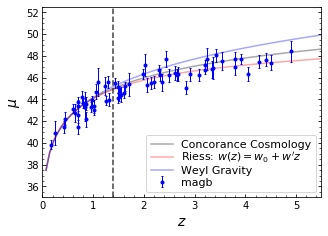

In [7]:
colnames = ['mag1', 'mag2', 'mag3', 'mag4', 'mag5', 'maga', 'magb']

for col in colnames:
    xdata = df.z
    ydata = df[col]
    yerr = df[col+'_err']
    plot_format(xdata=xdata, ydata=ydata, 
                xerr=None, yerr=yerr, 
                xLims=(0, 5.5), 
                yLims=(35, 52.5), ax=None,)# **pltKwargs)
    plt.show()

In [8]:
import statsmodels.api as sm

In [29]:
Y = df2.maga.values
X = df2.z.values

In [30]:
popt,pcov = curve_fit(distance_modulus, X, Y)

ValueError: Unable to determine number of fit parameters.

In [4]:
import statsmodels.api as sm

In [9]:
Y = df.maga.values
X = df.z.values 
X = sm.add_constant(X)

In [10]:
model = sm.OLS(Y, X)

In [11]:
results = model.fit()

In [12]:
results.params

array([ 42.79419573,   1.25420335])

In [13]:
results.tvalues

array([ 196.50135026,   14.58954394])

In [14]:
print(results.t_test([1, 0]))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.7942      0.218    196.501      0.000      42.360      43.229


In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     212.9
Date:                Wed, 08 Jan 2020   Prob (F-statistic):           1.76e-22
Time:                        17:09:47   Log-Likelihood:                -97.346
No. Observations:                  69   AIC:                             198.7
Df Residuals:                      67   BIC:                             203.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.7942      0.218    196.501      0.000      42.360      43.229
x1             1.2542      0.086     14.590      0.000       1.083       1.426
==============================================================================
Omnibus:                        9.027   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.070
Skew:                          -0.683   Prob(JB):                       0.0107
Kurtosis:                       4.135   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""